In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")

c:\Users\TEJKIRAN\anaconda3\envs\langgraph\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
llm.invoke("Hi").content

'Hello! How can I help you today?'

In [3]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AnyMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [4]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [5]:
workflow = StateGraph(MessagesState)
workflow.add_node('chatbot',call_model)
workflow.add_edge(START,'chatbot')
workflow.add_edge('chatbot',END)
app = workflow.compile()


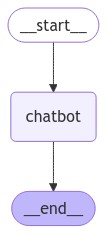

In [6]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [9]:
input={"messages":["Hi, My name is niti"]}

In [10]:
app.invoke(input)

{'messages': [HumanMessage(content='Hi, My name is niti', id='bf0a97a2-effe-4ee9-a56a-3f142cd0344d'),
  AIMessage(content='Hello, Niti. How can I help you today?', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-d14cd81b-955a-4290-98af-93a1f24134f4-0', usage_metadata={'input_tokens': 7, 'output_tokens': 12, 'total_tokens': 19})]}

In [11]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="Hello Niti, it's nice to meet you. Is there anything I can help you with today?", response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-ff5f09b2-2460-4da5-b73a-f34d61002d5e-0', usage_metadata={'input_tokens': 7, 'output_tokens': 22, 'total_tokens': 29})]}




In [12]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [13]:
search.invoke("what is a temprature in sf?")

"It's 60 degrees and foggy."

In [14]:
search.invoke("what is a weather in india?")

"It's 90 degrees and sunny."

In [15]:
search

StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'pydantic.v1.main.searchSchema'>, func=<function search at 0x00000257DB8DF490>)

In [16]:
tools=[search]

In [17]:
tool_node=ToolNode(tools)

In [18]:
llm_with_tool=llm.bind_tools(tools)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [82]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [20]:
response=call_model({"messages": ["hi how are you?"]})

In [21]:
response

{'messages': [AIMessage(content='I am well, thank you. How can I help you?', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-d3dfed4d-baa0-4394-9d61-c0b3c9fd3976-0', usage_metadata={'input_tokens': 42, 'output_tokens': 13, 'total_tokens': 55})]}

In [22]:
messages = response['messages']

In [24]:
last_message=messages[-1]

In [26]:
last_message.tool_calls

[]

In [27]:
response=call_model({"messages": ["what is a weather in India?"]})

In [28]:
response

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in India"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-60641203-aa4f-4327-bdb9-237ee2b99b81-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': '1ddd4f30-aac9-4680-9722-e97ac518a1e3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 44, 'output_tokens': 15, 'total_tokens': 59})]}

In [29]:
messages = response['messages']

In [31]:
last_messages = messages[-1]

In [33]:
last_messages.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in India'},
  'id': '1ddd4f30-aac9-4680-9722-e97ac518a1e3',
  'type': 'tool_call'}]

In [34]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [35]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

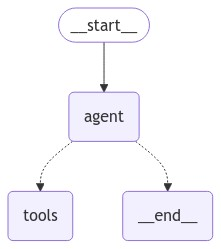

In [36]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [37]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', id='c17ecd3e-4e7b-45c5-a849-fc58162f8a3a'),
  AIMessage(content='I am doing fine, thank you for asking. How can I help you today?', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-66a243c7-dcd0-4905-a884-5bb76635b8c9-0', usage_metadata={'input_tokens': 42, 'output_tokens': 17, 'total_tokens': 59})]}

In [38]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', id='2c5ccfac-3825-4d46-8147-de5ff051a971'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "What is the weather in San Francisco?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-554db3c4-f216-4aee-981b-261b3df33747-0', tool_calls=[{'name': 'search', 'args': {'query': 'What is the weather in San Francisco?'}, 'id': 'bc1b0970-9c12-46a7-bf08-db3de89a1b0e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 43, '

In [39]:
workflow.add_edge("tools", 'agent')

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [40]:
app = workflow.compile()

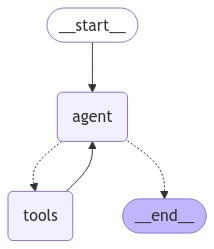

In [41]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "What is the weather in San Francisco"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-70c34f4f-5e2b-40e1-9cea-9fd0d97ebe1c-0', tool_calls=[{'name': 'search', 'args': {'query': 'What is the weather in San Francisco'}, 'id': 'd3a4a357-d0f7-4375-aba2-ee6fff85355c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 43, 'output_tokens': 19, 'total_tokens': 62})]}


here is output from

In [89]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [90]:
# Define a new graph
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

In [91]:
app3 = workflow3.compile(checkpointer = memory)

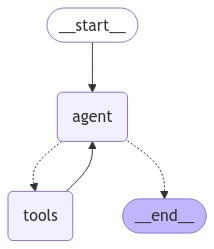

In [92]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [94]:
config = {"configurable": {"thread_id": "7"}}

In [96]:
events = app3.stream(
    {"messages": ["Hi there! My name is Tej."]}, config, stream_mode="values"
)

In [97]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Tej.
================================== Ai Message ==================================

Hi Tej. How can I help you today?


In [98]:
events = app3.stream(
    {"messages": ["can you tell me what was my name?"]}, config, stream_mode="values"
)

In [99]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what was my name?
================================== Ai Message ==================================

I cannot fulfill this request. I do not have the ability to tell you what your name is.


In [100]:
memory.get(config)

{'v': 1,
 'ts': '2024-12-21T16:43:57.743882+00:00',
 'id': '1efbfbac-5f00-6669-8004-b76b44eb79c7',
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is Tej.', id='6598a75e-b940-45c7-ae11-cdd9bdd9ac73'),
   AIMessage(content='Hi Tej. How can I help you today?', response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-8b9d9dce-8009-48da-a79c-d02fc539a410-0', usage_metadata={'input_tokens': 45, 'output_tokens': 10, 'total_tokens': 55}),
   HumanMessage(content='can you tell me what was my name?', id='857ca24c-7d36-4fcb-82b1-f